- This notebook computes the correlation with the snRNA-seq data from Allen at the Group or subclass level.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import anndata 
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi = 180, dpi_save = 300, frameon = False, figsize = (4,4), fontsize=8,facecolor = 'white')



Utility functions

In [2]:
import scipy.stats

def get_cluster_sizes(adata,cluster_column):
    ''' Get a data frame of cluster sizes'''
    cell_mtx = pd.DataFrame(np.ones((adata.shape[0],1)),index = adata.obs[cluster_column] , columns=['size'] )
    return cell_mtx.groupby(by=cluster_column).sum()

def get_clustser_mean_expression_matrix(adata, cluster_column):
    """ get a dataframe of mean gene expression of each cluster"""
    cell_exp_mtx = pd.DataFrame(adata.X, index =adata.obs[cluster_column] , columns=adata.var_names )
    return cell_exp_mtx.groupby(by=cluster_column).mean()

def get_cluster_expression_std_matrix(adata,cluster_column):
    """ get a dataframe of gene expression standard deviation of each cluster"""
    cell_exp_mtx = pd.DataFrame(adata.X, index=adata.obs[cluster_column], columns=adata.var_names)
    return cell_exp_mtx.groupby(by=cluster_column).std()

def get_cluster_expression_fraction_matrix(adata, cluster_column, exp_threshold=0):
    """ Get a dataframe of the fraction of cells that express each gene in each cluster """
    cell_exp_mxt = pd.DataFrame(adata.X, index=adata.obs[cluster_column], columns=adata.var_names)
    cluster_exp_fraction = (cell_exp_mxt > exp_threshold).groupby(by = cluster_column).mean()
    return cluster_exp_fraction

def differential_expression_score_between_two_clusters(
        cluster_size1, cluster_size2,
        mean_exps1, mean_exps2,
        std_exps1,std_exps2, 
        exp_fracs1, exp_fracs2,
        fold_change_threshold = 2, pval_threshold=1e-2, exp_frac_threshold = 0.5,
        relative_exp_threshold = 0.7, pvalue_baseline = np.exp(-20)
                                                       ):
    """ Calculate the differential expression score between two clusters """
    # Mask of differentially expressed genes 
    N_genes = len(mean_exps1)
    de_masks = np.ones(N_genes,dtype=bool)

    # calculate the fold changes of mean expressions
    fold_changes = mean_exps2 / (mean_exps1 + 1e-20)
    de_masks = de_masks & ((fold_changes > fold_change_threshold) | (fold_changes < (1/fold_change_threshold)))

    # Calculate the p-values using t-test
    t_stats,pvals = scipy.stats.ttest_ind_from_stats(
        mean1 = mean_exps1, std1 = std_exps1,nobs1 = cluster_size1 * np.ones(N_genes,dtype = int),
        mean2 = mean_exps2, std2 = std_exps2,nobs2 = cluster_size2 * np.ones(N_genes,dtype = int),
        )
    de_masks = de_masks & (pvals < pval_threshold)

    # The marker genes should be generally expressed in at least one cluster
    de_masks = de_masks & (np.maximum(exp_fracs1, exp_fracs2)> exp_frac_threshold)

    # The marker genes should have a bimodal expression patterns
    relative_exp = np.absolute(exp_fracs1 - exp_fracs2) / (np.maximum(exp_fracs1, exp_fracs2) + 1e-20 )
    de_masks = de_masks & (relative_exp > relative_exp_threshold)

    # calculate the differential expression scores for each gene
    de_scores = -np.log(pvals + pvalue_baseline) * de_masks

    return np.sum(de_scores)


def calculate_differential_expression_score_matrix(adata1,adata2,cluster_column, exp_threshold=0):
    """ Calculate a matrix of differential expression scores between clusters """
    # Calculate matrix of cluster properties for the first adata
    cluster_sizes1 = get_cluster_sizes(adata1,cluster_column)
    cluster_mean_exp1 = get_clustser_mean_expression_matrix(adata1, cluster_column)
    cluster_exp_std1 = get_cluster_expression_std_matrix(adata1,cluster_column)
    cluster_exp_fraction1 = get_cluster_expression_fraction_matrix(adata1,cluster_column,
                                                                  exp_threshold = exp_threshold)
    
    # Calculate matrix of cluster properties for the second adata
    cluster_sizes2 = get_cluster_sizes(adata2,cluster_column)
    cluster_mean_exp2 = get_clustser_mean_expression_matrix(adata2, cluster_column)
    cluster_exp_std2 = get_cluster_expression_std_matrix(adata2,cluster_column)
    cluster_exp_fraction2 = get_cluster_expression_fraction_matrix(adata2,cluster_column,
                                                                  exp_threshold = exp_threshold)
    
    #Initialize the DE score matrix
    #Note, the cluster names in both dataset should be the same
    cluster_ids = np.array(cluster_sizes1.index)
    N_clusters = len(cluster_ids)
    de_score_mtx = pd.DataFrame(np.zeros((N_clusters,N_clusters)) , index = cluster_ids, columns=cluster_ids)

    # Fill the DE Score matrix
    for i in range(N_clusters):
        cluster_id1 = cluster_ids[i]
        cluster_size1 = int(cluster_sizes1.loc[cluster_id1])
        mean_exps1  = np.array(cluster_mean_exp1.loc[cluster_id1])
        std_exps1 = np.array(cluster_exp_std1.loc[cluster_id1])
        exp_fracs1 = np.array(cluster_exp_fraction1.loc[cluster_id1])

        for j in range(N_clusters):
            cluster_id2 = cluster_ids[j]
            cluster_size2 = int(cluster_sizes2.loc[cluster_id2])
            mean_exps2  = np.array(cluster_mean_exp2.loc[cluster_id2])
            std_exps2 = np.array(cluster_exp_std2.loc[cluster_id2])
            exp_fracs2 = np.array(cluster_exp_fraction2.loc[cluster_id2])

            # get the DE score 
            de_score = differential_expression_score_between_two_clusters(
                cluster_size1, cluster_size2,
                mean_exps1, mean_exps2,
                std_exps1, std_exps2,
                exp_fracs1,exp_fracs2
            )
            de_score_mtx.loc[cluster_id1,cluster_id2] = de_score
            # de_score_mtx.loc[cluster_id2,cluster_id1] = de_score
    return de_score_mtx
    
def calculate_correlation_matrix(adata1,adata2,cluster_column):
    """Calculate gene expression correlations between clusters"""
    cluster_mean_exp1 = get_clustser_mean_expression_matrix(adata1,cluster_column)
    cluster_mean_exp2 = get_clustser_mean_expression_matrix(adata2,cluster_column)

    # Initialize the corealtion matrix 
    cluster_ids = np.array(cluster_mean_exp1.index)
    N_clusters = len(cluster_ids)
    correlation_mtx = pd.DataFrame(np.ones((N_clusters,N_clusters)), index=cluster_ids, columns=cluster_ids)

    # Fill the correlation matrix
    for i in range(N_clusters):
        cluster_id1 = cluster_ids[i]
        mean_exps1 = np.array(cluster_mean_exp1.loc[cluster_id1])

        for j in range(N_clusters):
            cluster_id2 = cluster_ids[j]
            mean_exps2 = np.array(cluster_mean_exp2.loc[cluster_id2])

            r,p = scipy.stats.pearsonr(mean_exps1,mean_exps2)

            correlation_mtx.loc[cluster_id1,cluster_id2] = r
    
    return correlation_mtx
    

In [3]:
from scipy.spatial.distance import squareform
from fastcluster import linkage

def seriation(Z,N,cur_index):
    """
    input:
         - Z is a hierarchcal tree (dendrogram)
         - N is the number of points given to the clustsering process
         - cur_index is the position in the tree for the recursive traversal
    output:
         - order implied by the hierarchical tree z

         seriation computes teh order implied by a hierarchical tree (dendrogram) 
         
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))

def compute_serial_matrix(dist_mat,method = 'ward'):
    """
        input:
            - dist_mat is a distance matrix
            - method = ['ward','single','average','complete']
        output:
            - seriated_dist is the input dist_mat
              but with re-orered rows and columns
              according to the seriation, i.e. the order implied by hierarchical tree
            - res_order is the order implied by the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transfroms a distance matrix into a sorted distance matrix according to the order
        implied by the hierarchial tree (dendrogram)

    """
    N = len(dist_mat)
    # flat_dist_mat = squareform(dist_mat)
    flat_dist_mat = scipy.spatial.distance.pdist(dist_mat, metric='euclidean')
    res_linkage = linkage(flat_dist_mat,method = method, preserve_input = True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))

    # we can not use this since the matrix is not symmetric (since we are not comparing cell type clusters from 
    # with in a single adata )
    # a,b = np.triu_indices(N,k=1)
    # seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    # seriated_dist[b,a] = seriated_dist[a,b]
    a,b = np.unravel_index(np.arange(N), dist_mat.shape) # get the coordinate index in unraveled matrix
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a]  , [res_order[j] for j in b]]

    return seriated_dist, res_order, res_linkage

def sort_distance_dataframe(df):
    
    ids = list(df.index)
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(np.array(df))
    ordered_ids = [ids[i] for i in res_order]
    return pd.DataFrame(ordered_dist_mat, index=ordered_ids, columns=ordered_ids)











- Load all the MERFISH data

In [ ]:
%%time

# load 1311 posterior 
Donor_1311_posterior_adata  = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER2_Gpe_Gpi_CaPu_1311__MERFISH_annotated.h5ad')
print('load 1311 posterior .....')

# # load 2427 posterior 
Donor_2427_posterior_adata = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER4_Gpe_Gpi_2724__MERFISH_annotated.h5ad')
print('load 2427 posterior .....')

# # load 2427 anterior 
Donor_2427_anterior_adata = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER1_CaPuNAC_2427__MERFISH_annotated.h5ad')
print('load 2427 anterior .....')

# # load 3924 anterior 
Donor_3924_anterior_adata = anndata.read_h5ad(r'./../../MERFISH_adata_QC/mapmycell_annotated_adata/MER5_CaPuNAc_3924__MERFISH_annotated.h5ad')
print('load 3924 anterior  .....')

load 1311 posterior .....
load 2427 posterior .....
load 2427 anterior .....
load 3924 anterior  .....
CPU times: user 1min 18s, sys: 14.9 s, total: 1min 33s
Wall time: 1min 43s


- Concatenate the data

- Mask sure the same order of genes is used in all samples and replace count with raw counts.

In [5]:
# make sure the same order of genes is used in all samples  and replace count with raw counts
common_gns = np.array(Donor_2427_posterior_adata.var_names)
Donor_1311_posterior_adata.X = Donor_1311_posterior_adata.layers['X_raw']
Donor_1311_posterior_adata = Donor_1311_posterior_adata[:,common_gns].copy()
Donor_1311_posterior_adata.obsm['X_spatial'] = Donor_1311_posterior_adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in Donor_1311_posterior_adata.obsm else Donor_1311_posterior_adata.obsm['X_spatial']

Donor_2427_posterior_adata.X = Donor_2427_posterior_adata.layers['X_raw']
Donor_2427_posterior_adata = Donor_2427_posterior_adata[:,common_gns].copy()
Donor_2427_posterior_adata.obsm['X_spatial'] = Donor_2427_posterior_adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in Donor_2427_posterior_adata.obsm else Donor_2427_posterior_adata.obsm['X_spatial']

Donor_2427_anterior_adata.X = Donor_2427_anterior_adata.obsm['X_raw']
Donor_2427_anterior_adata = Donor_2427_anterior_adata[:,common_gns].copy()
Donor_2427_anterior_adata.obsm['X_spatial'] = Donor_2427_anterior_adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in Donor_2427_anterior_adata.obsm else Donor_2427_anterior_adata.obsm['X_spatial']

Donor_3924_anterior_adata.X = Donor_3924_anterior_adata.layers['X_raw']
Donor_3924_anterior_adata = Donor_3924_anterior_adata[:,common_gns].copy()
Donor_3924_anterior_adata.obsm['X_spatial'] = Donor_3924_anterior_adata.obsm['X_spatial_rotated'] if 'X_spatial_rotated'  in Donor_3924_anterior_adata.obsm else Donor_3924_anterior_adata.obsm['X_spatial']

In [6]:
# concatenate the data
adata_MERFISH = anndata.concat([Donor_1311_posterior_adata,Donor_2427_posterior_adata,Donor_2427_anterior_adata,Donor_3924_anterior_adata],
                       label = 'samples',
                        keys= ['Donor_1311_posterior','Donor_2427_posterior','Donor_2427_anterior','Donor_3924_anterior'],
                        fill_value=0,
                        join='outer',
                        merge='same' ,
                        index_unique='_' # make the cell index unique
                        ) 


In [7]:
adata_MERFISH

AnnData object with n_obs × n_vars = 3250780 × 673
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'samples'
    obsm: 'X_raw', 'X_spatial', 'X_spatial_rotated', 'X_umap', 'X_pca'
    layers: 'X_raw'

In [8]:
adata_MERFISH.layers['X_raw'] =  adata_MERFISH.X.copy()

- Load in the snRNA-seq data 

In [ ]:
# load the snRNA-seq data
import os
snRNA_seq_flpath  = r'./HumanBG_scRNA_seq_Allen/Human_HMBA_basalganglia_AIT_pre-print.h5ad'
print(f'Running analysis for  {os.path.basename(snRNA_seq_flpath)}')
adata_snRNA = anndata.read_h5ad(snRNA_seq_flpath)
adata_snRNA.X = adata_snRNA.raw.X.copy()


Running analysis for  Human_HMBA_basalganglia_AIT_pre-print.h5ad


- Restrict the snRNA-seq data to common gene 

In [10]:
# restrict to the common genes 
common_genes = list(set(adata_MERFISH.var_names).intersection(adata_snRNA.var_names))
adata_MERFISH = adata_MERFISH[:,common_genes]
adata_snRNA = adata_snRNA[:,common_genes]

- Rename some columns to make them consistent between the two datasets.

In [11]:
adata_MERFISH.obs = adata_MERFISH.obs.rename(columns={'Class_name':'Class','Subclass_name':'Subclass','Group_name':'Group'})

- Normalize the data

In [12]:
%%time
# apply log normalization t
adata_MERFISH.layers['X_raw'] = adata_MERFISH.X.copy()
adata_snRNA.layers['X_raw'] = adata_snRNA.X.copy()


<timed exec>:3: ImplicitModificationWarning: Setting element `.layers['X_raw']` of view, initializing view as actual.


CPU times: user 21.3 s, sys: 17.2 s, total: 38.5 s
Wall time: 38.5 s


In [13]:
%%time
sc.pp.normalize_total(adata_MERFISH, target_sum=1e4)
sc.pp.log1p(adata_MERFISH)

sc.pp.normalize_total(adata_snRNA, target_sum=1e4)
sc.pp.log1p(adata_snRNA)

CPU times: user 14.2 s, sys: 669 ms, total: 14.8 s
Wall time: 13.1 s


In [14]:
adata_snRNA.X = adata_snRNA.X.toarray()
adata_snRNA

AnnData object with n_obs × n_vars = 1034819 × 672
    obs: 'Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster', 'cluster_id', 'cell_type_ontology_term', 'load_id', 'donor_id', 'assay', 'assay_ontology_term_id', 'organism', 'organism_ontology_term_id', 'development_stage', 'anatomical_region', 'anatomical_region_merged', 'anatomical_region_ontology_term_id', 'brain_region_ontology_term_id', 'self_reported_sex', 'self_reported_sex_ontology_term_id', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'disease', 'disease_ontology_term_id', 'suspension_type', 'is_primary_data', 'atac_confidently_mapped_read_pairs', 'atac_fraction_of_genome_in_peaks', 'atac_fraction_of_high_quality_fragments_in_cells', 'atac_fraction_of_high_quality_fragments_overlapping_tss', 'atac_fraction_of_high_quality_fragments_overlapping_peaks', 'atac_fraction_of_transposition_events_in_peaks_in_cells', 'atac_mean_raw_read_pairs_per_cell', 'atac_median_high_quality_fragments_per_cell', 'atac_

- Compute the correlation matrix

In [15]:
correlation_mtx = calculate_correlation_matrix(adata_MERFISH,adata_snRNA,cluster_column = 'Subclass')

/tmp/ipykernel_291421/2575559163.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return cell_exp_mtx.groupby(by=cluster_column).mean()


In [30]:
np.median(np.diag(correlation_mtx.values))

np.float64(0.5468658208847046)

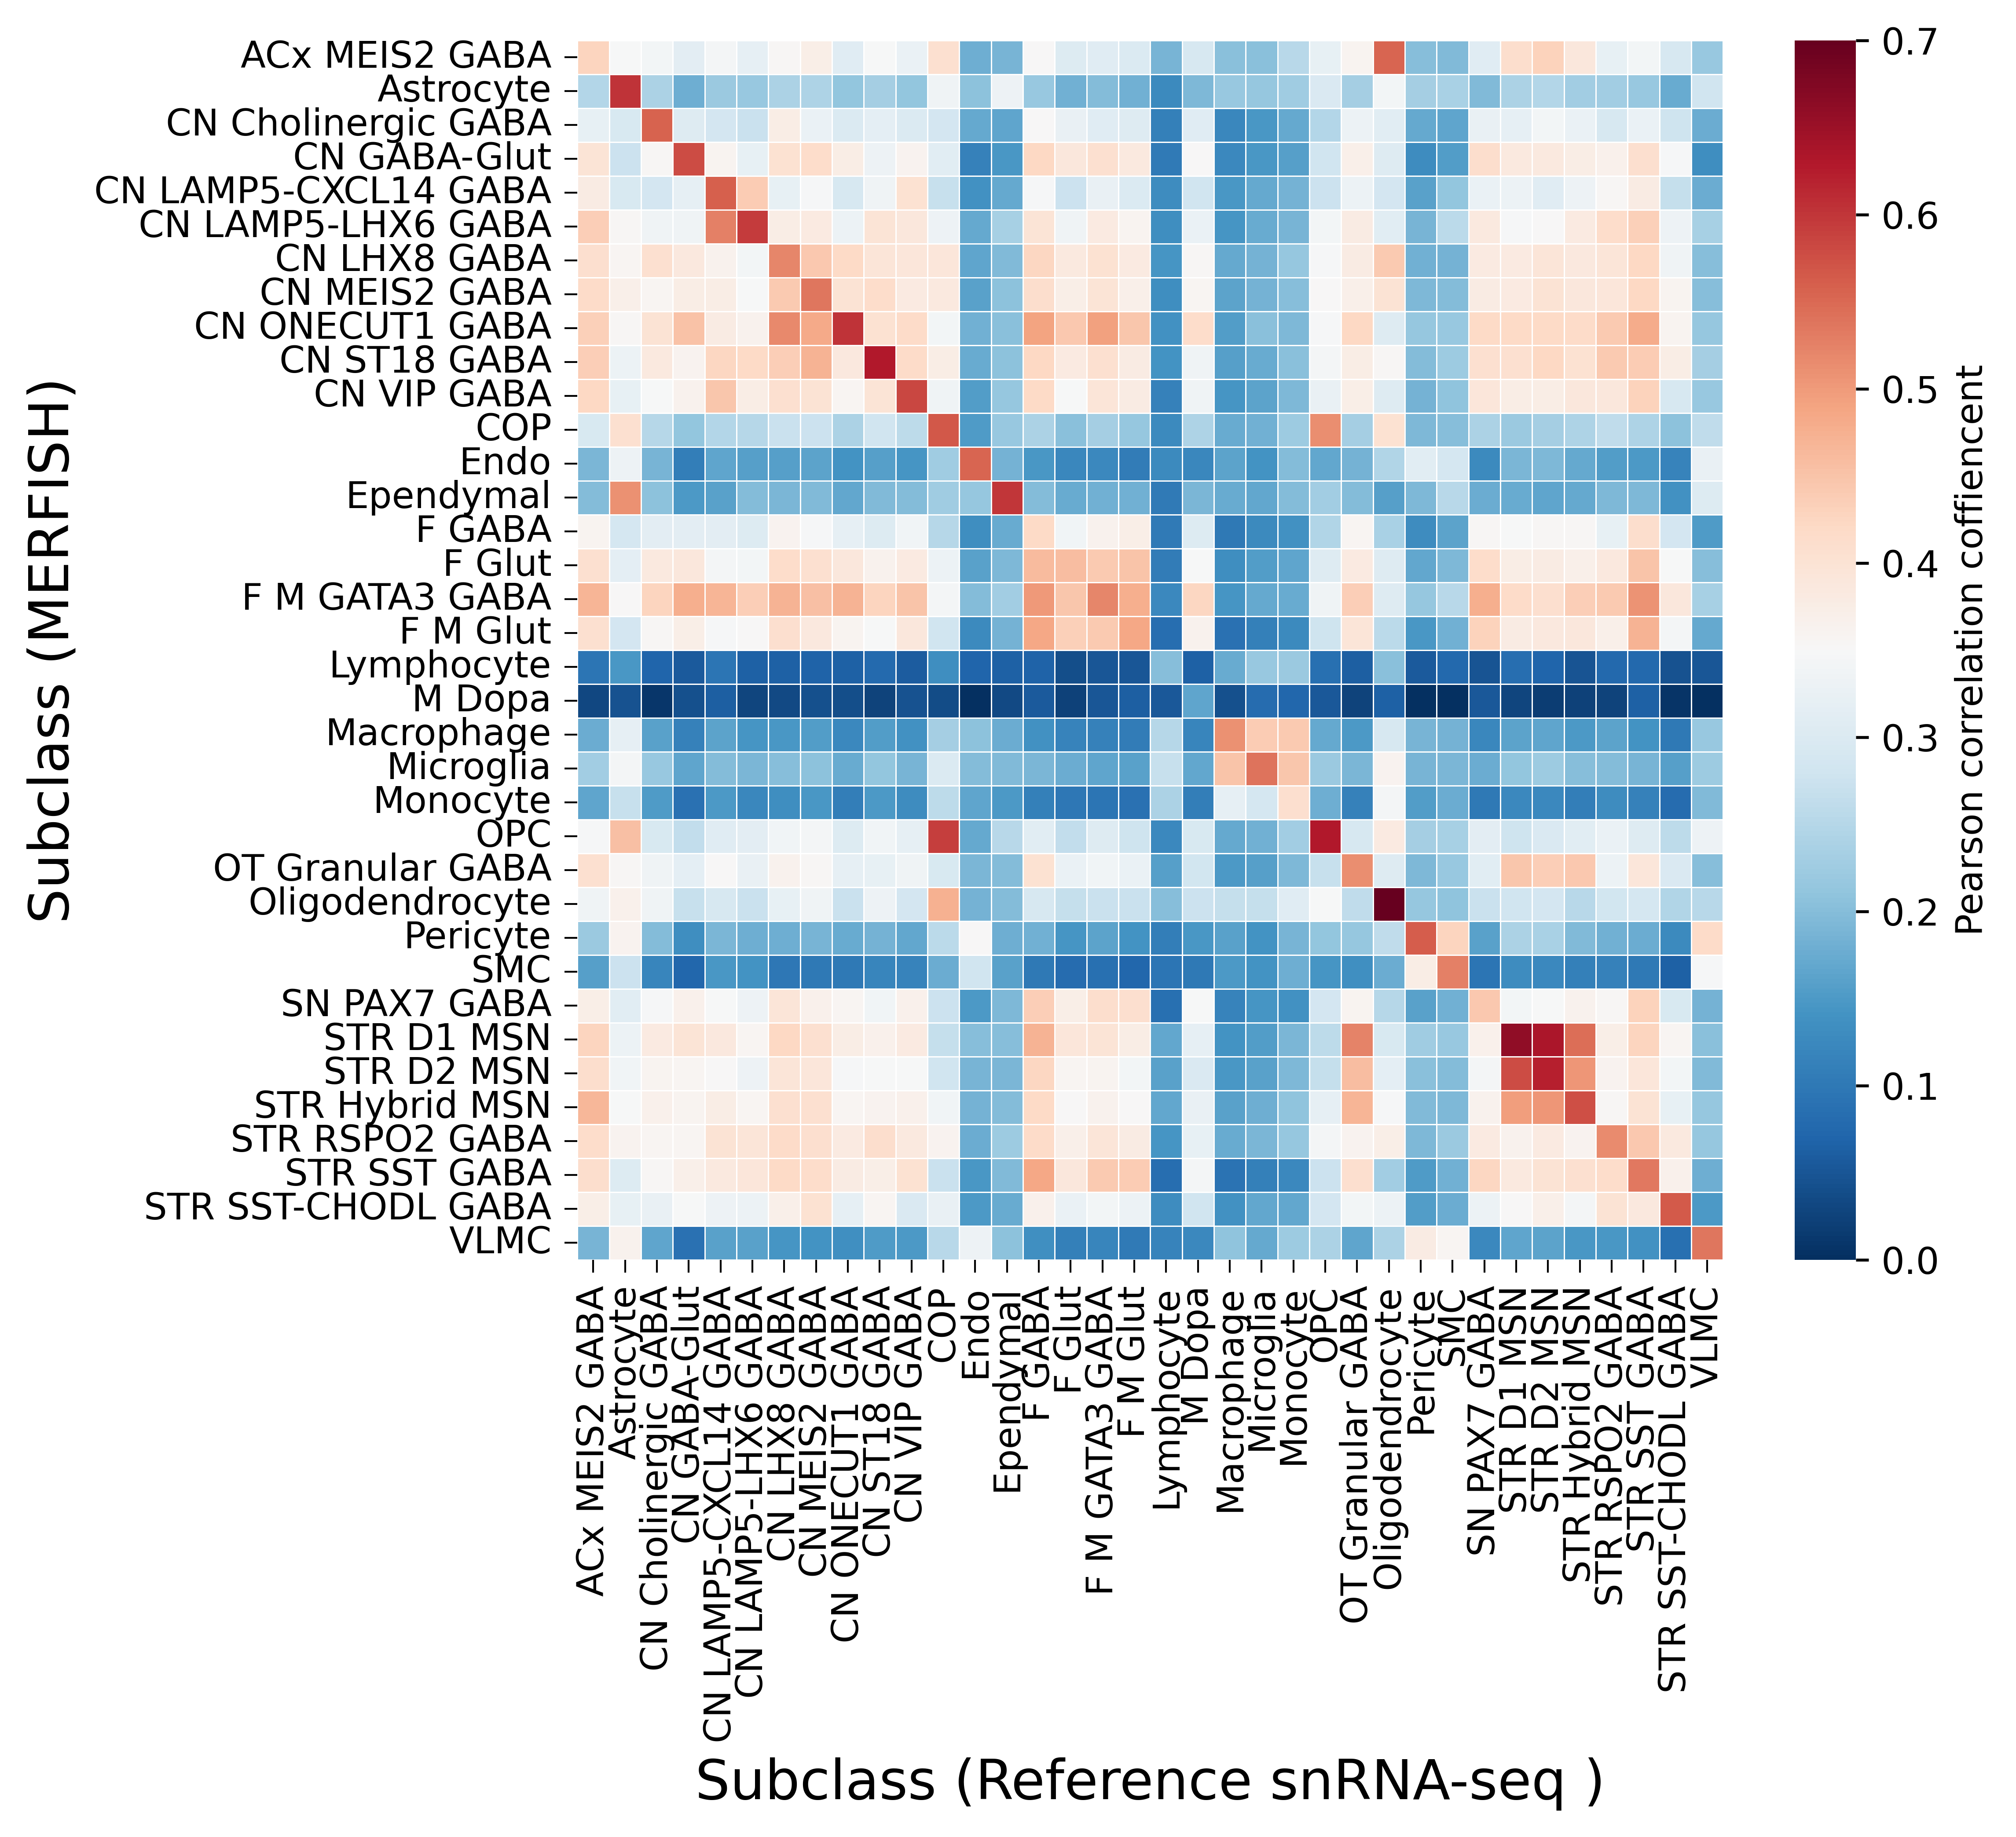

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 15
plt.style.use('default')
fig,ax = plt.subplots(1,1, dpi = 300, figsize = (7,6))
handle = sns.heatmap(correlation_mtx, 
cmap='RdBu_r',
vmax=.7, vmin=0, 
linewidths=0.3,
ax = ax,
xticklabels = np.array(correlation_mtx.columns),
yticklabels = np.array(correlation_mtx.columns),
cbar_kws = {'label':'Pearson correlation coffiencent'}
)
ax.tick_params(axis='both',width = 0.5)
plt.grid(False)
ax.set_xlabel('Subclass (Reference snRNA-seq )',fontdict={'fontsize':15})
ax.set_ylabel('Subclass (MERFISH)',fontdict={'fontsize':15})
plt.savefig(r'./figures/Figure1/correlationMatrix_MERFISH_AllenSnRNA_seq.tif',bbox_inches = 'tight')
plt.savefig(r'./figures/Figure1/correlationMatrix_MERFISH_AllenSnRNA_seq.png',bbox_inches = 'tight')
plt.savefig(r'./figures/Figure1/correlationMatrix_MERFISH_AllenSnRNA_seq.eps',bbox_inches = 'tight')
plt.show()
